# Imports

In [224]:
from torchvision.models import resnet18, resnet50
import torchvision.transforms as transforms
import torch
import torch.nn as nn

from sklearn.cluster import DBSCAN
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
import os

# Data Paths

In [ ]:
image_dir = '/kaggle/input/logo-similarity-data/data/extracted_logos/'
output_dir = '/kaggle/working/labeled_data'
os.makedirs(output_dir, exist_ok=True)

# Transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    # transforms.GaussianBlur(51),
    # transforms.GaussianBlur(31),
])

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet standard input size
    # transforms.CenterCrop((40, 40)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Remove Transparency

In [ ]:
def remove_transparency(im, bg_color=(255, 255, 255)):
    if im.mode == 'RGBA':
        # Create white RGB background and paste RGBA onto it using alpha
        bg = Image.new('RGB', im.size, bg_color)
        bg.paste(im, mask=im.split()[-1])  # Use alpha channel as mask
        return bg

    elif im.mode == 'LA':
        # Create white L background and paste LA onto it using alpha
        bg = Image.new('L', im.size, bg_color[0])  # Use first channel for grayscale
        bg.paste(im.convert('L'), mask=im.split()[-1])
        return bg

    elif im.mode in ('RGB', 'L'):
        return im  # No transparency, return as is

    else:
        # For any other mode, convert to RGB
        return im.convert('RGB')

# Feature Extraction

In [ ]:
def process_image_from_path(path, channel='RGB', feature_extractor=None):
    img = Image.open(path).convert(channel)
    img = remove_transparency(img)
    
    if feature_extractor == 'resnet':
        img_tensor = transform_resnet(img)
    else:
        img_tensor = transform(img)
    
    return img_tensor

def get_resnet_features():
    model = resnet50(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove last FC layer
    model.eval()
    return model

def extract_features(model, img_tensor):
    with torch.no_grad():
        features = model(img_tensor.unsqueeze(0))
    return features.squeeze().flatten()


# Show random image

Text(0.5, 1.0, 'fluidmasteruk.com.png')

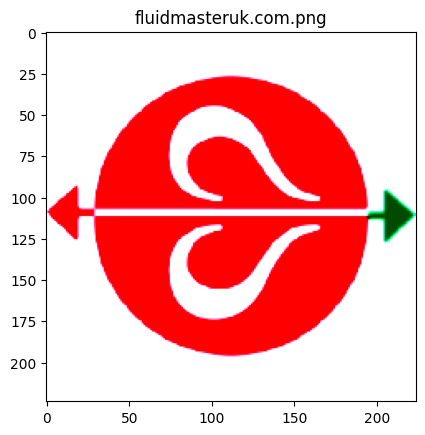

In [222]:
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

idx = np.random.randint(len(image_files))

path = os.path.join(image_dir, image_files[idx])
img = process_image_from_path(path, channel='RGBA', feature_extractor='resnet')
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(image_files[idx])


# Hyperparameters

In [ ]:
hyperparams = {
    'eps': 1.2,
    'min_samples': 2
}

# Feature Extraction

In [ ]:
resnet_model = get_resnet_features().to('cuda' if torch.cuda.is_available() else 'cpu')

resnet_features = []
for filename in tqdm(image_files, desc="Extracting ResNet features"):
    path = os.path.join(image_dir, filename)
    img_tensor = process_image_from_path(path, channel='RGB', feature_extractor='resnet')
    features = extract_features(resnet_model, img_tensor.to('cuda' if torch.cuda.is_available() else 'cpu'))
    resnet_features.append(features.cpu().numpy())

# Convert to numpy array for clustering
features_array = np.array(resnet_features)

# Fit DBSCAN

In [215]:
dbscan = DBSCAN(eps=hyperparams['eps'], min_samples=hyperparams['min_samples'])
labels = dbscan.fit_predict(features_array)

# Delete old dir

In [216]:
!rm -rf labeled_data
os.makedirs(output_dir, exist_ok=True)

# Correlate label and domain & Save

### Save each image starting with the label in the name for an easier navigation in a file explorer, the classes will be sorted and the class members will also be sorted by the domain name so the grouping will be a lot more visible

In [217]:
for filename, label in zip(image_files, labels):
    old_path = os.path.join(image_dir, filename)
    new_filename = f"{label}_{filename}"
    new_path = os.path.join(output_dir, new_filename)
    shutil.copy2(old_path, new_path)

# Count noise
### Count the images labeled as '-1' (noise/singular classes)

In [218]:
!find labeled_data -maxdepth 1 -type f -name '-1*' | wc -l

1634


# Count total files

In [219]:
!find labeled_data -maxdepth 1 -type f | wc -l

3356


# Save .zip

In [ ]:
!zip -r labeled_data.zip labeled_data